In [1]:
using MKL
using PhysicalUnits, LinearAlgebra
using MoireIVC.LLHF
using MoireIVC.LLHF_Plot
using MoireIVC.LLTDHF
using CairoMakie
CairoMakie.activate!()
Threads.nthreads()

24

In [2]:
@show LLHF.define_MoTe2system().B
AVL_sys = LLHF.LLHFSysPara(
    ϵ = 4, 
    a_Moire = 0.352nm/2.0/sind(2.1/2.0) / sqrt(2.0), 
    D = 20nm,
    ratio12 = sqrt(3.0),
    cosθ = 0.0,
    sinθ = 1.0,
)
@show AVL_sys;

(LLHF.define_MoTe2system()).B = 0.0020726748066780807
AVL_sys = MoireIVC.LLHF.LLHFSysPara(37.947, 0.0052492, 4.0, 6.7913374843684045, 1.7320508075688772, 0.0, 1.0, 26.62870201326543, 20.0, 2.0586620785190313, 0.006218024420034243, 44.95073014307693, 174.86779690864748, [6.7913374843684045, -0.0], [0.0, 3.9209805247576943], 0.9251764209394056, [0.9251764209394056, 0.0], [0.0, 1.6024525670317809], 1.904625613727915, -4.423757977113575 + 0.0im, 4.4691389092876355)
0.0020726748066780807
AVL_sys = MoireIVC.LLHF.LLHFSysPara(37.947, 0.0052492, 4.0, 6.7913374843684045, 1.7320508075688772, 0.0, 1.0, 26.62870201326543, 20.0, 2.0586620785190313, 0.006218024420034243, 44.95073014307693, 174.86779690864748, [6.7913374843684045, -0.0], [0.0, 3.9209805247576943], 0.9251764209394056, [0.9251764209394056, 0.0], [0.0, 1.6024525670317809], 1.904625613727915, -4.423757977113575 + 0.0im, 4.4691389092876355)


In [3]:
N1 = 32; N2 = 64;
num_para = LLHF_init_with_lambda(0.0, AVL_sys; 
    N1 = N1, N2 = N2, LL = 0
);
num_para.H0 .= 0.0;

In [4]:
sym = [LLHF.Trans(1,1); LLHF.PT(0,:PT)];
ρ_AVL = LLHF_solve(num_para; coherence = 0.0, 
    error_tolerance = 1E-10, max_iter_times = 100, 
    post_process_times = 100, post_procession = sym,
    complusive_mixing=false, complusive_mixing_rate=0.5, 
    stepwise_output = true, final_output = true
);

1 	 DM error:0.6840710477221135 	 E/S:-0.7716470764642076
update rate = 0.5: unstable solution with higher energy
2 	 DM error:0.433107192580421 	 E/S:-0.19538846973645657
update rate = 0.5: unstable solution with higher energy
3 	 DM error:0.40450501203450273 	 E/S:-0.05656994682479448
update rate = 1.0: unstable solution with lower energy
4 	 DM error:0.5028706360561326 	 E/S:-0.14830555215802343
update rate = 1.0: unstable solution with lower energy
5 	 DM error:0.14861456817991667 	 E/S:-1.2454203406994693
update rate = 1.0: unstable solution with lower energy
6 	 DM error:0.03254367015040013 	 E/S:-1.2651581187231948
update rate = 1.0: unstable solution with lower energy
7 	 DM error:0.0075251211807868335 	 E/S:-1.2665439384777506
update rate = 1.0: unstable solution with lower energy
8 	 DM error:0.0018752960485658179 	 E/S:-1.2666406409203546
update rate = 1.0: unstable solution with lower energy
9 	 DM error:0.00047894777430059334 	 E/S:-1.2666473989642733
update rate = 1.0: un

In [5]:
function plot_rect_bands!(ax, rho; para::LLHF.LLHFNumPara, unit=:W0, color=:blue, others...)
    N1 = para.N1; N2 = para.N2
    2N1 != N2 && error("LLHF_plot_band only works with 2N1=N2")

    if unit == :W0
        u = para.system.W0
    else
        u = meV
    end

    bands = LLHF.band(rho; para=para)
    bv1 = [bands[i+1,2i+1,1]./u for i in 0:N1-1]
    bc1 = [bands[i+1,2i+1,2]./u for i in 0:N1-1]
    bv2 = [bands[1,i%N2+1,1]./u for i in N2:-2:0]
    bc2 = [bands[1,i%N2+1,2]./u for i in N2:-2:0]
    bv3 = [bands[(N1-i)%N1+1,(2i)%N2+1,1]./u for i in 0:N1]
    bc3 = [bands[(N1-i)%N1+1,(2i)%N2+1,2]./u for i in 0:N1]
    b1 = [bv1; bv2; bv3]
    b2 = [bc1; bc2; bc3]
    L = length(b1)-1
    lines!(ax, 0:L, b1, color=color, others...)
    lines!(ax, 0:L, b2, color=color, others...)

end
function plot_rect_phase!(ax, ρ; para::LLHF.LLHFNumPara, others...)

    phase_color = LLHF_Plot.phase_color
    ql_cross = LLHF_Plot.ql_cross

    N1 = para.N1; N2 = para.N2
    Gx = para.system.G_Moire
    Gy = Gx * sqrt(3.0)
    
    k1range = floor(Int64,-1.4N1):floor(Int64,1.4N1)
    k2range = floor(Int64,-0.6N2):floor(Int64,0.6N2)


    al = [ angle(ρ[1+k1-floor(Int64,k1//N1)*N1, 1+k2-floor(Int64,k2//N2)*N2,2,1])
        for k1 in k1range, k2 in k2range
    ]
    for I in CartesianIndices(al)
        k1 = k1range[I[1]]; k2 = k2range[I[2]];
        al[I] += ql_cross(floor(k1//N1), floor(k2//N2), k1/N1, k2/N2)
        while al[I] <= -π
            al[I] += 2π
        end
        while al[I] > π
            al[I] -= 2π
        end
    end

    kx = k1range./N1 * Gx
    ky = k2range./N2 * Gy

    heatmap!(ax, kx, ky, al;
        colormap = phase_color, colorrange = (-pi,pi), others...
    )

    
    lines!(ax, 0.5Gx.*[1;1;-1;-1;1], 0.5Gy.*[1;-1;-1;1;1]; color=:white)
    

    L = Gx
    ylims!(ax, -L, L)
    xlims!(ax, -L, L)
end

plot_rect_phase! (generic function with 1 method)

In [6]:
N_arrows = 30
data = LLHF_Plot.LLHF_plot_realspace_data(ρ_AVL; para = num_para,
    N = N_arrows, xlimits = (-0.8,0.8), ylimits = (-0.8,0.8)
);

In [53]:
AVL_plot = Figure(size = (600, 900))
ax_bands = Axis(AVL_plot[1,1],
    xticks=([0,N1,2N1,3N1], ["γ", "γ", "γ", "γ"]), 
    xticksvisible = false,
    xgridcolor = :black,
    limits=((0,3N1), nothing),
    alignmode = Outside(5,0,0,0),
)
plot_rect_bands!(ax_bands, ρ_AVL; 
    para=num_para, unit=:meV, color=:black
)
Label(AVL_plot[1,1,Top()], "    meV", 
    halign = :left, valign = :bottom,
    padding = (0, 0, 0, 10),
)


ax_phase = Axis(AVL_plot[1,2], aspect = DataAspect(),
    subtitle = "IVC phase winding=2",
    xticksvisible = false, xticklabelsvisible = false,
    yticksvisible = false, yticklabelsvisible = false,
)
plot_rect_phase!(ax_phase, ρ_AVL; para=num_para,)
Colorbar(AVL_plot[1,3], colormap = LLHF_Plot.phase_color, 
    colorrange = (-pi,pi),
    ticks = (-pi:0.5pi:pi, ["-π","-π/2","0","π/2","π"]),
    alignmode = Outside()
)

ax_realspace = Axis(AVL_plot[2:3,1:3], aspect = 1.0, 
    subtitle = rich("vortex lattice in type-II SC (PT)",
        "    S", subscript("z"), "=0    ν=1"
    ),
    xticksvisible = false, yticksvisible = false,
    xgridvisible = false, ygridvisible = false,
    xticklabelsvisible = false, yticklabelsvisible = false,
)
ar_T = LLHF_plot_realspace!(ax_realspace, ρ_AVL;
    para = num_para, N = N_arrows, inputdata = data,
    xlimits = (-0.8,0.8), ylimits = (-0.8,0.8), 
    arrowscale = 1, arrowsize = 3, arrowcolor = :n,
    text = false, linewidth = 0.5
)
Cx = 0.25
Cy = Cx/sqrt(3.0)
scatter!(ax_realspace, 
    Cx.*[-3;-3;-3;-1;-1;-1], Cy.*[-3;1;5;-5;-1;3], markersize = 10, color = :limegreen,
)
scatter!(ax_realspace, 
    Cx.*[1;1;1;3;3;3], Cy.*[-3;1;5;-5;-1;3], markersize = 10, color = :limegreen,
)



# AVL_plot

┌ Warning: `arrows` are deprecated in favor of `arrows2d` and `arrows3d`.
└ @ Makie C:\Users\newuser\.julia\packages\Makie\UjJJY\src\basic_recipes\arrows.jl:164
┌ Warning: arrowsize has been deprecated in favor of tipwidth and tiplength.
└ @ Makie C:\Users\newuser\.julia\packages\Makie\UjJJY\src\basic_recipes\arrows.jl:204


Scatter{Tuple{Vector{Point{2, Float64}}}}

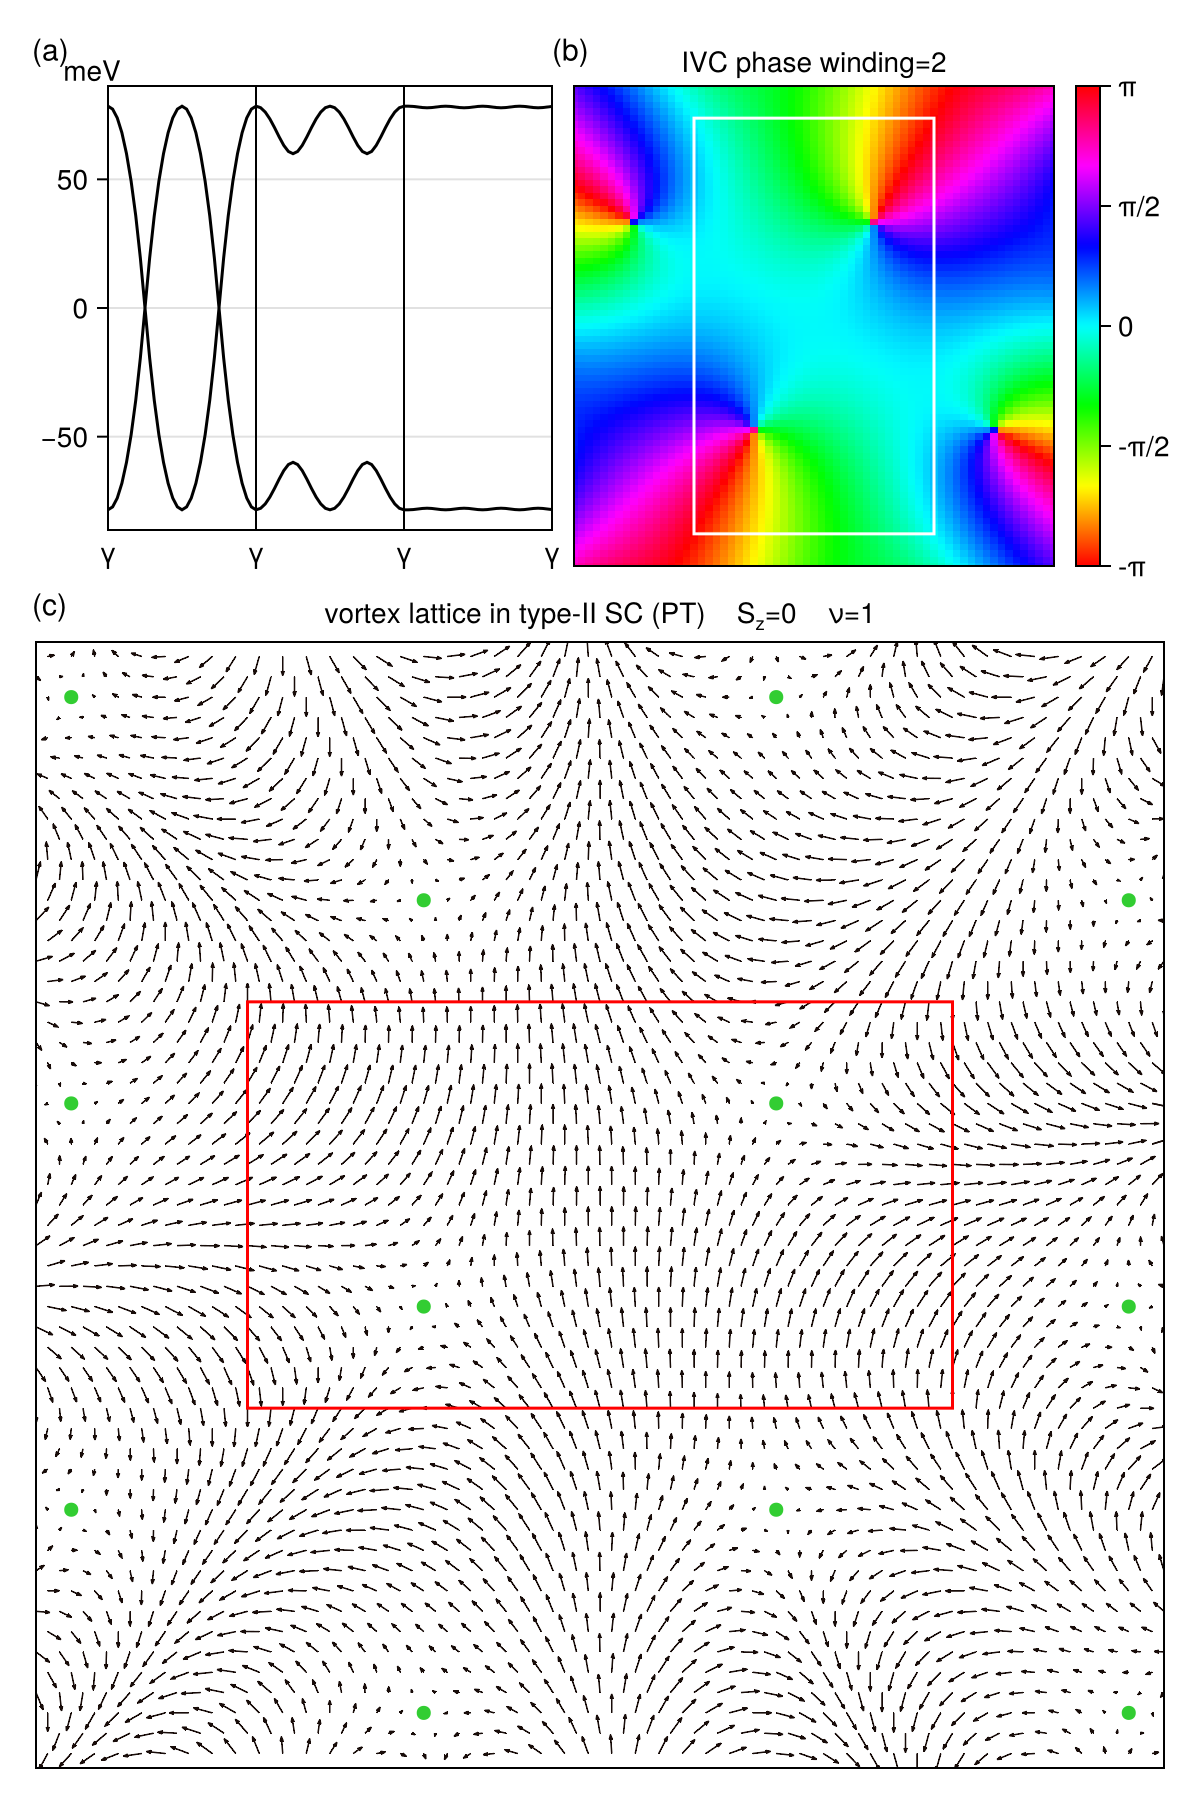

In [54]:
for (label,i,j) in zip(["(a)", "(b)", "(c)"], 
    [1;1;2], [1;2;1]
)
    Label(AVL_plot[i,j,Top()], label, 
        fontsize = 15, font = "TeX Gyre Heros",
        padding = (0, 0, 10, 0),
        halign = :left, valign = :top,
    )
end

colgap!(AVL_plot.layout, 0)
colsize!(AVL_plot.layout, 1, 260)
rowsize!(AVL_plot.layout, 1, 240)
rowgap!(AVL_plot.layout, 10)

AVL_plot

In [55]:
save("AbrikosovVL.pdf", AVL_plot)

CairoMakie.Screen{PDF}
